In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.colors import LogNorm, rgb2hex
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['figure.figsize'] = [6, 3.5]
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.linewidth'] = 1.2

from utils.utils import *
from utils.utils_synthetic import create_network
import utils.HTC_utils as HTC
import utils.dyngdim.dyngdim as dyngdim
from utils.dyngdim.plotting import compute_dim_max, plot_results

import random
from PIL import Image

import networkx as nx

import seaborn as sns
import starbars
from pingouin import partial_corr
#from statannotations.Annotator import Annotator

from scipy.stats import ttest_ind, pearsonr
from scipy.linalg import expm

import os
os.environ["OPENBLAS_NUM_THREADS"] = "30"

folder_results = 'results/'
folder_figures = 'figures/'

session = 1

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [ ]:
%load_ext autoreload
%autoreload 2

# Local dimension and brain axis at different parcellations

In [2]:
### LOAD RESULTS
which = 'dimensionality'
ress_dim = load_result(which, var_name='dim', thr='mask', include_subctx=False)

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 100 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 500 - total 51 - thr mask - subctx False ########


In [3]:
### Load myelin
from neuromaps.datasets import fetch_annotation, available_annotations
from netneurotools import datasets as nntdata
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fslr_to_fslr
from enigmatoolbox.permutation_testing import spin_test, shuf_test

In [4]:
avg_dim_local = []
dim_locals = []
data_loaders = []
myelins = []

for parc in parcellations:
    ### Load results
    control = data_loader(which='control', ses=session, parc=parc, include_subctx=False, thr='mask')
    
    ress = ress_dim.loc[ress_dim['parc'] == parc].drop(columns='parc')
    
    dim_control_names = ress.loc[ress['name']=='control']['sub'].values
    
    dim_controls_local = ress.loc[ress['name']=='control']['dim_all'].values
    
    data_loaders.append(control)
    avg_dim_local.append(dim_controls_local.mean(axis=0))
    dim_locals.append(np.stack(dim_controls_local))
    
    ### Load myelin
    # Download parcellation
    schaefer = nntdata.fetch_schaefer2018('fslr32k')[f'{parc}Parcels7Networks']

    # Create parcellator
    parcellator = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')

    # Download map
    myelinmap = fetch_annotation(source='hcps1200', desc='myelinmap')

    ### Parcellate
    myelin_parc = parcellator.fit_transform(myelinmap, 'fsLR')
    
    myelins.append(myelin_parc)

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


/home/barzon/.local/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/barzon/.local/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/barzon/.local/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/barzon/.local/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/barzon/.local/lib/python3.8/site-packages/seaborn/categori

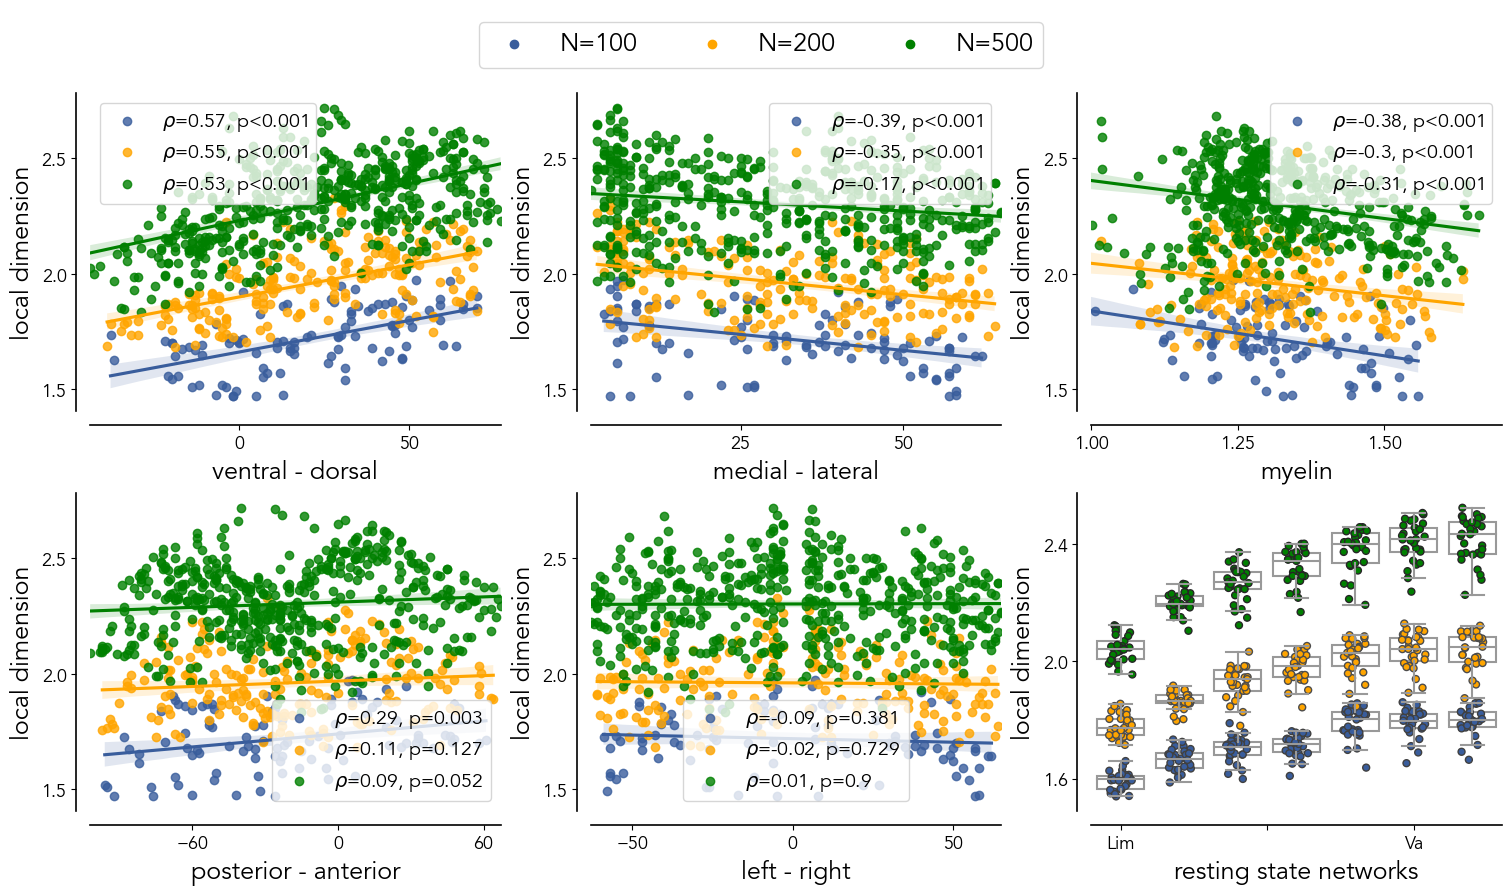

In [5]:
figsize=(15,8)
nrows = 2
ncols = 3
height_ratios = [1,1]
width_ratios = [1,1,1]
title_size = 24
ylabel_size = 20
offset = 10
letter_size = 24
legend_size = 14
my_color = my_cmap(0.6)
my_colors = [my_cmap(0.6), 'orange', 'green']

### Generate figure
fig = plt.figure(figsize=figsize, layout='constrained')
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios, width_ratios=width_ratios)

axs = [fig.add_subplot(tt) for tt in gs]

for idx_parc, parc in enumerate(parcellations):
    rois = data_loaders[idx_parc].get_rois()
    coords = rois[['R','A','S']].values
    data_x = [coords[:,2], np.abs(coords[:,0]), coords[:,1], coords[:,0]]
    
    # Get RSN data
    roi_rsn = rois['ROI Name'].values
    roi_rsn = np.array( [tmp.split('_')[2] for tmp in roi_rsn] )
    rsn_names = np.unique(roi_rsn).astype(str)

    rsn_idx = [np.where(roi_rsn==tmp)[0] for tmp in rsn_names]
    rsn_idx = [np.where(roi_rsn==tmp)[0] for tmp in rsn_names]
    
    avg_dim = [dim_locals[idx_parc][:,tmp_idx].mean(axis=1) for tmp_idx in rsn_idx]
    avg_dim = np.stack( avg_dim )

    new_rsn_names = np.array( ['Fp', 'Dmn', 'Da', 'Lim', 'Va', 'Sm', 'Vis'] )
    
    avg_dim_rsn = pd.DataFrame(avg_dim.T, columns=new_rsn_names)

    idx_to_plot = np.argsort(avg_dim.mean(axis=1))#[::-1]
    avg_dim_rsn = avg_dim_rsn[new_rsn_names[idx_to_plot]]
    
    ### Z-axis
    ax = axs[0]
    x = data_x[0]
    y = avg_dim_local[idx_parc]
    rho, pval = pearsonr(x, y)
    if pval<1e-3:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    sns.regplot(x=x, y=y, ax=ax, label=label, color=my_colors[idx_parc])
    sns.despine(offset=offset, bottom=False, ax=ax)
    ax.set_ylabel('local dimension')
    ax.set_xlabel('ventral - dorsal')
    ax.legend(prop={'size':legend_size})

    ### |x|-axis
    ax = axs[1]
    x = data_x[1]
    y = avg_dim_local[idx_parc]
    rho, pval = pearsonr(x, y)
    if pval<1e-3:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    sns.regplot(x=x, y=y, ax=ax, label=label, color=my_colors[idx_parc])
    sns.despine(offset=offset, bottom=False, ax=ax)
    ax.set_ylabel('local dimension')
    ax.set_xlabel('medial - lateral')
    ax.legend(prop={'size':legend_size})
    
    ### y-axis
    ax = axs[3]
    x = data_x[2]
    y = avg_dim_local[idx_parc]
    rho, pval = pearsonr(x, y)
    if pval<1e-3:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    sns.regplot(x=x, y=y, ax=ax, label=label, color=my_colors[idx_parc])
    sns.despine(offset=offset, bottom=False, ax=ax)
    ax.set_ylabel('local dimension')
    ax.set_xlabel('posterior - anterior')
    ax.legend(prop={'size':legend_size})
    
    ### x-axis
    ax = axs[4]
    x = data_x[3]
    y = avg_dim_local[idx_parc]
    rho, pval = pearsonr(x, y)
    if pval<1e-3:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    sns.regplot(x=x, y=y, ax=ax, label=label, color=my_colors[idx_parc])
    sns.despine(offset=offset, bottom=False, ax=ax)
    ax.set_ylabel('local dimension')
    ax.set_xlabel('left - right')
    ax.legend(prop={'size':legend_size})
    
    ### Myelin
    ax = axs[2]
    x = myelins[idx_parc]
    y = avg_dim_local[idx_parc]
    rho, pval = pearsonr(x, y)
    if pval<1e-3:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else:
        label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    sns.regplot(x=x, y=y, ax=ax, label=label, color=my_colors[idx_parc])
    sns.despine(offset=offset, bottom=False, ax=ax)
    ax.set_xlabel('myelin')
    ax.set_ylabel('local dimension')
    ax.set_xlim(1,1.7)
    ax.legend(prop={'size':legend_size})
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    
    ### RSN
    ax = axs[5]
        
    sns.boxplot(data=avg_dim_rsn, fliersize=0, color='white', ax=ax, zorder=2)
    sns.stripplot(data=avg_dim_rsn, dodge=True, alpha=1.0, jitter=0.2, edgecolor='gray', linewidth=1, ax=ax, zorder=1, color=my_colors[idx_parc], label=f'N={parc}')
    sns.despine(offset=offset, bottom=False, ax=ax)
    ax.set_ylabel('local dimension')
    ax.set_xlabel('resting state networks')
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

###
ax_fake = fig.add_axes([0.5, .9, 0.2, 0.2])  # Adjust values as needed

# Add fake scatter points to create the legend
for color, parc in zip(my_colors, parcellations):
    ax_fake.scatter([], [], color=color, label=f'N={parc}')

# Hide the axis lines and ticks on the fake axis
ax_fake.axis('off')

# Add the legend to the fake axis
ax_fake.legend(ncol=3)

for ax in axs:
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    
plt.savefig(folder_figures+'fig_suppl_local_dim_axis.png', dpi=200, bbox_inches='tight')    

plt.show()

# Global dimension - control vs stroke - at different parcellations & comparison w spectral dimension

In [10]:
color_control = my_cmap(0.6)
color_stroke = 'orange'#my_cmap(0.25)
cs = (color_control, color_stroke)

In [319]:
dim_controls = []
dim_strokes = []

for parc in parcellations:
    ### Compute structural features
    control = data_loader(which='control', ses=session, parc=parc, include_subctx=False, thr='mask')
    stroke = data_loader(which='stroke', ses=session, parc=parc, include_subctx=False, thr='mask')

    dim_control = ress_dim.loc[ress_dim['name'] == 'control']['dim_avg'].values
    dim_stroke = ress_dim.loc[ress_dim['name'] == 'stroke']['dim_avg'].values
    
    dim_controls.append(dim_control)
    dim_strokes.append(dim_stroke)

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 100 - total 51 - thr mask - subctx False ########
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 500 - total 51 - thr mask - subctx False ########


In [320]:
### LOAD RESULTS
which = 'spectral_dimension'
ress_spec_dim = load_result(which, var_name='dim', thr='mask', include_subctx=False)

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 100 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 500 - total 51 - thr mask - subctx False ########


/tmp/ipykernel_107780/2803399477.py:87: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, label=label, c=cs[0], edgecolors='black')
/tmp/ipykernel_107780/2803399477.py:87: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, label=label, c=cs[0], edgecolors='black')
/tmp/ipykernel_107780/2803399477.py:87: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoide

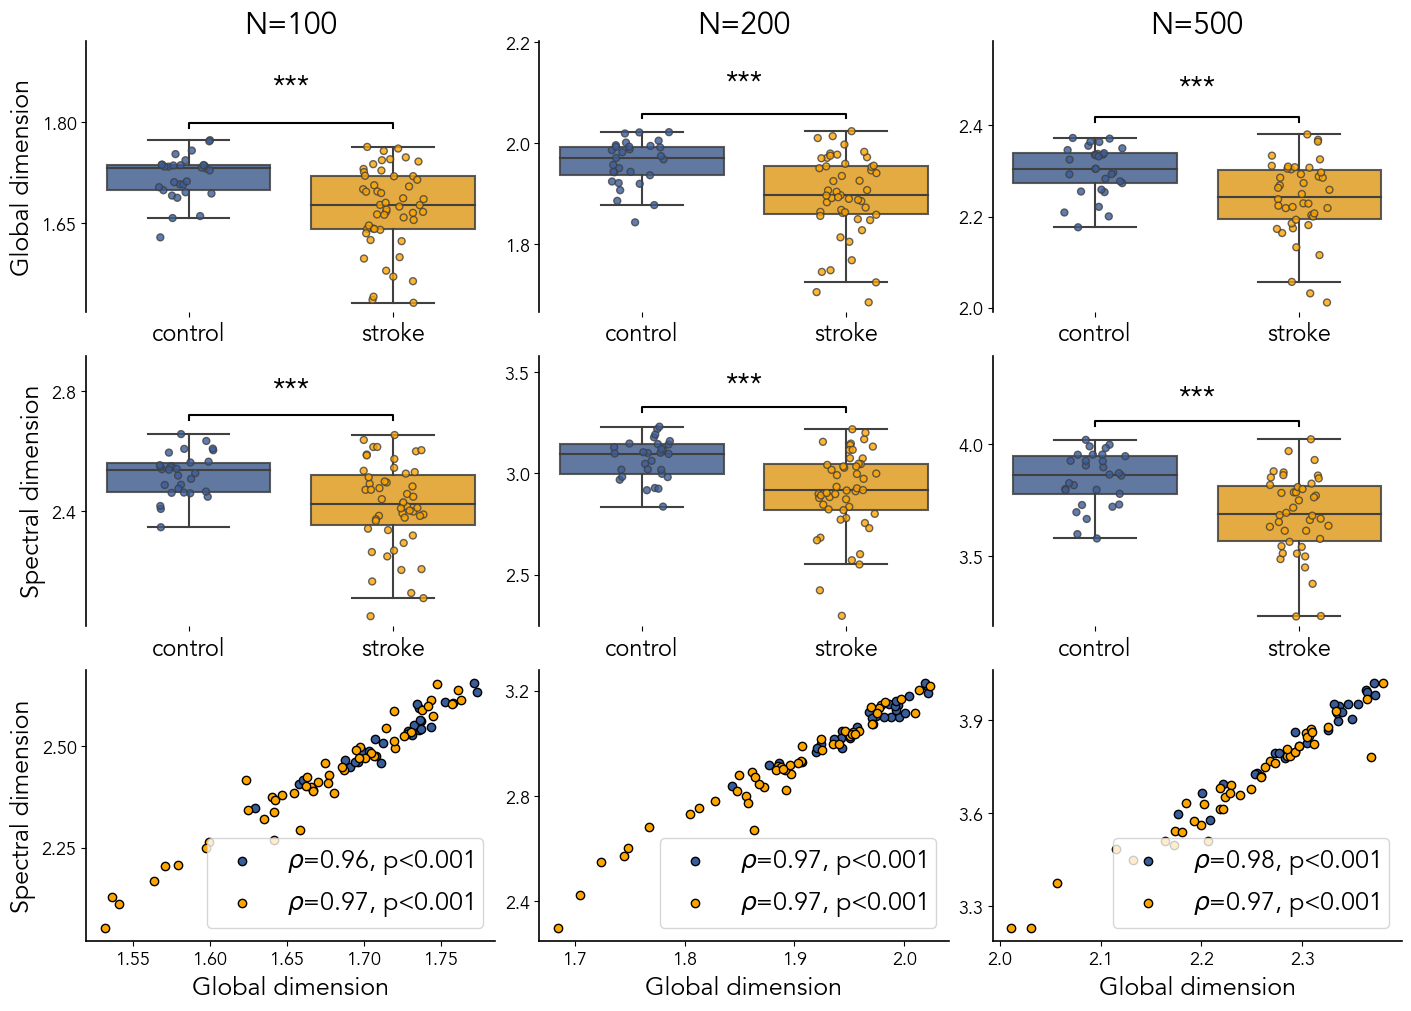

In [322]:
figsize=(14,10)
nrows = 3
ncols = 3
height_ratios = [1,1,1]
width_ratios = [1,1,1]
title_size = 24
ylabel_size = 20
offset = 10
letter_size = 24
legend_size = 14
fontsize_annot = 20
my_color = my_cmap(0.6)
my_colors = [my_cmap(0.6), 'orange', 'green']

### Generate figure
fig = plt.figure(figsize=figsize, layout='constrained')
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios, width_ratios=width_ratios)

axs = [fig.add_subplot(tt) for tt in gs]

### Global dimension
for idx_parc, parc in enumerate(parcellations):
    ax = axs[idx_parc]
    x = 'name'
    y = 'dim_avg'
    hue = None
    df = ress_dim.loc[ress_dim['parc'] == parc].drop(columns='parc')
    
    ttt = ttest_ind(df.loc[ress_dim['name'] == 'control']['dim_avg'].values, df.loc[ress_dim['name'] == 'stroke']['dim_avg'].values)
    ttt = np.round(ttt, 2)
    if ttt[1]<0.001: label = f'(t={ttt[0]}, pval<0.001)'
    else: label = f'(t={ttt[0]}, pval={ttt[1]})'
    
    sns.boxplot(data=df, x=x, y=y, hue=hue, palette=cs, boxprops={'alpha': 0.85}, fliersize=0, ax=ax)
    sns.stripplot(data=df, x=x, y=y, hue=hue, palette=cs, ax=ax, dodge=True, alpha=0.8, jitter=0.15, edgecolor='gray', linewidth=1)
    sns.despine(bottom=True, ax=ax)
    plt.xlabel('')
    ax.xaxis.set_tick_params(labelsize=ylabel_size-3)#(fontsize=ylabel_size-4)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.set_xlabel('')#ax.set_xlabel(f'N={parc}')
    if idx_parc % ncols ==0: ax.set_ylabel('Global dimension')
    else: ax.set_ylabel('')
    starbars.draw_annotation([('control', 'stroke', 1e-3)], ax=ax, fontsize=fontsize_annot)
    ax.set_title(f'N={parc}')
    
### Local dimension
for idx_parc, parc in enumerate(parcellations):
    idx_parc += ncols
    ax = axs[idx_parc]
    x = 'name'
    y = 'dim_avg'
    hue = None
    df = ress_spec_dim.loc[ress_spec_dim['parc'] == parc].drop(columns='parc')
    
    ttt = ttest_ind(df.loc[ress_spec_dim['name'] == 'control']['dim_avg'].values, df.loc[ress_spec_dim['name'] == 'stroke']['dim_avg'].values)
    ttt = np.round(ttt, 2)
    if ttt[1]<0.001: label = f'(t={ttt[0]}, pval<0.001)'
    else: label = f'(t={ttt[0]}, pval={ttt[1]})'
    
    sns.boxplot(data=df, x=x, y=y, hue=hue, palette=cs, boxprops={'alpha': 0.85}, fliersize=0, ax=ax)
    sns.stripplot(data=df, x=x, y=y, hue=hue, palette=cs, ax=ax, dodge=True, alpha=0.8, jitter=0.15, edgecolor='gray', linewidth=1)
    sns.despine(bottom=True, ax=ax)
    plt.xlabel('')
    ax.xaxis.set_tick_params(labelsize=ylabel_size-3)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.set_xlabel('')#ax.set_xlabel(f'N={parc}')
    if idx_parc % ncols ==0: ax.set_ylabel('Spectral dimension')
    else: ax.set_ylabel('')
    starbars.draw_annotation([('control', 'stroke', 1e-3)], ax=ax, fontsize=fontsize_annot)
    
### Scatter plot
for idx_parc, parc in enumerate(parcellations):
    idx_parc += 2*ncols
    ax = axs[idx_parc]
    x = 'name'
    y = 'dim_avg'
    hue = None
    
    # Controls
    df = ress_dim.loc[ress_dim['parc'] == parc].drop(columns='parc')
    x = df.loc[ress_dim['name'] == 'control']['dim_avg'].values
    df = ress_spec_dim.loc[ress_spec_dim['parc'] == parc].drop(columns='parc')
    y = df.loc[ress_spec_dim['name'] == 'control']['dim_avg'].values
    rho, pval = pearsonr(x, y)
    if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    ax.scatter(x, y, label=label, c=cs[0], edgecolors='black')
    
    # Stroke
    df = ress_dim.loc[ress_dim['parc'] == parc].drop(columns='parc')
    x = df.loc[ress_dim['name'] == 'stroke']['dim_avg'].values
    df = ress_spec_dim.loc[ress_spec_dim['parc'] == parc].drop(columns='parc')
    y = df.loc[ress_spec_dim['name'] == 'stroke']['dim_avg'].values
    rho, pval = pearsonr(x, y)
    if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    ax.scatter(x, y, label=label, c=cs[1], edgecolors='black')
    
    sns.despine(ax=ax)
    #plt.xticks(fontsize=ylabel_size-4)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.set_xlabel('Global dimension')
    if idx_parc % ncols ==0: ax.set_ylabel('Spectral dimension')
    else: ax.set_ylabel('')
    ax.legend()

plt.savefig(folder_figures+'fig_suppl_global_spectral_dim_axis.png', dpi=200, bbox_inches='tight')

plt.show()

# Global dimension and integration with Louvain and SBM

In [187]:
tmp_control = data_loader(which='control', ses=session, parc=200, include_subctx=False, thr='mask')
pos = tmp_control.get_rois()[['R','A', 'S']].values

mat = tmp_control.load_matrix(0)
mat = mat / mat.max()
mat[mat<1e-1] = 0
G = nx.from_numpy_array(mat)

######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
- Loading sub-040


In [186]:
pos.shape

(200, 3)

In [167]:
### GET SPECIFIC PARCELLATION
ress_200 = ress_dim.loc[ress_dim['parc'] == parc].drop(columns='parc')

In [202]:
### Load example of community detection
ex_mod = np.load('results/example_Louvain.npy')
ex_sbm = np.load('results/example_SBM.npy')

In [152]:
### Load modularity data
parc = 200
ses = 1

control = data_loader(which='control', ses=ses, parc=parc, include_subctx=False, thr='mask')
stroke = data_loader(which='stroke', ses=ses, parc=parc, include_subctx=False, thr='mask')

mod_control, mod_stroke = [], []
mod_sbm_control, mod_sbm_stroke = [], []

for i, tmp in enumerate(control):
    try:
        mod_sbm = np.load(f'results/modularity_sbm/mod_sbm_{control.names[i]}_parc_{parc}.npy')
    except:
        mod_sbm = np.nan
        
    try:
        mod = np.load(f'results/modularity/mod_{control.names[i]}_parc_{parc}.npy')
    except:
        mod = np.nan
    
    mod_control.append(mod), mod_sbm_control.append(mod_sbm)

for i, tmp in enumerate(stroke):
    try:
        mod_sbm = np.load(f'results/modularity_sbm/mod_sbm_{stroke.names[i]}_parc_{parc}.npy')
    except:
        mod_sbm = np.nan
        
    try:
        mod = np.load(f'results/modularity/mod_{stroke.names[i]}_parc_{parc}.npy')
    except:
        mod = np.nan
        
    mod_stroke.append(mod), mod_sbm_stroke.append(mod_sbm)

######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
- Loading sub-040
- Loading sub-041
- Loading sub-042
- Loading sub-043
- Loading sub-044
- Loading sub-045
- Loading sub-046
- Loading sub-047
- Loading sub-048
- Loading sub-049
- Loading sub-050
- Loading sub-051
- Loading sub-052
- Loading sub-055
- Loading sub-057
- Loading sub-059
- Loading sub-060
- Loading sub-061
- Loading sub-062
- Loading sub-063
- Loading sub-064
- Loading sub-065
- Loading sub-066
- Loading sub-067
- Loading sub-068
- Loading sub-069
- Loading sub-070
- Loading sub-071
- Loading sub-072
- Loading sub-200
- Loading sub-201
- Loading sub-202
- Loading sub-203
- Loading sub-204
- Loading sub-205
- Loading sub-206
- Loading sub-208
- Loading sub-209
- Loading sub-210
- Loading sub-213
- Loading sub-216
- Loading sub-219
- Loading sub-222
- Loading sub-224
- Loading sub-226
- Loading sub-227
- Loadi

/tmp/ipykernel_107780/888719490.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)
/tmp/ipykernel_107780/888719490.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)


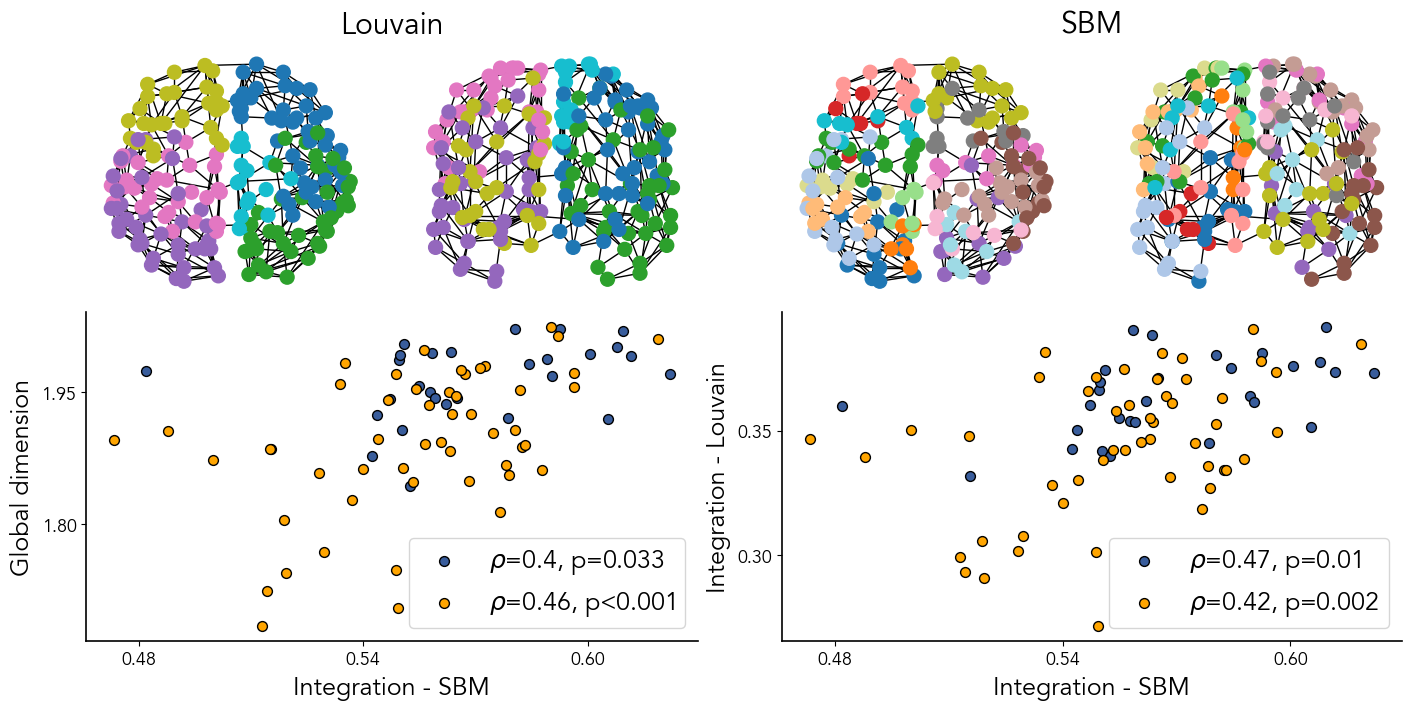

In [220]:
figsize=(14,7)

nrows = 2
ncols = 4
height_ratios = [0.8, 1]
width_ratios = [1, 1, 1, 1]
node_size = 100

fig = plt.figure(figsize=figsize, layout='constrained')
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios, width_ratios=width_ratios)

### Example communities detected w Louvain
ax = fig.add_subplot(gs[0,0])
nx.draw(G, pos=pos[:,[0,1]], ax=ax, node_color=ex_mod, node_size=node_size, cmap=sns.color_palette("tab10", as_cmap=True))

ax = fig.add_subplot(gs[0,1])
nx.draw(G, pos=pos[:,[0,2]], ax=ax, node_color=ex_mod, node_size=node_size, cmap=sns.color_palette("tab10", as_cmap=True))

ax = fig.add_subplot(gs[0,:2])
ax.axis('off')
ax.set_title('Louvain')

### Example communities detected w SBM
ax = fig.add_subplot(gs[0,2])
nx.draw(G, pos=pos[:,[0,1]], ax=ax, node_color=ex_sbm, node_size=node_size, cmap=sns.color_palette("tab20", as_cmap=True))

ax = fig.add_subplot(gs[0,3])
nx.draw(G, pos=pos[:,[0,2]], ax=ax, node_color=ex_sbm, node_size=node_size, cmap=sns.color_palette("tab20", as_cmap=True))

ax = fig.add_subplot(gs[0,2:])
ax.axis('off')
ax.set_title('SBM')

### Relation btw mod_SMB and global dim
ax = fig.add_subplot(gs[1,:2])

x = 1 - np.array(mod_sbm_control)
y = ress_200.loc[ress_200['name']=='control']['dim_avg'].values
rho, pval = pearsonr(x, y)
if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
plt.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)

x = 1 - np.array(mod_sbm_stroke[:-1])
y = ress_200.loc[ress_200['name']=='stroke']['dim_avg'].values
rho, pval = pearsonr(x, y)
if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
plt.scatter(x, y, c=cs[1], label=label, edgecolors='black', s=50)

plt.legend()
plt.ylabel('Global dimension')
plt.xlabel('Integration - SBM')
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))

### Relation btw mod_SMB and mod_Louvain
ax = fig.add_subplot(gs[1,2:])

x = 1 - np.array(mod_sbm_control)
y = 1 - np.array(mod_control)
rho, pval = pearsonr(x, y)
if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
plt.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)

x = 1 - np.array(mod_sbm_stroke[:-1])
y = 1 - np.array(mod_stroke[:-1])
rho, pval = pearsonr(x, y)
if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
plt.scatter(x, y, c=cs[1], label=label, edgecolors='black', s=50)

plt.legend()
plt.ylabel('Integration - Louvain')
plt.xlabel('Integration - SBM')
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
ax.xaxis.set_major_locator(MaxNLocator(nbins=3))

sns.despine()

plt.savefig(folder_figures+'fig_suppl_SBM.png', dpi=200, bbox_inches='tight')

plt.show()

# Global dimension and behavior

In [337]:
### LOAD RESULTS
which = 'dimensionality'
ress_dim = load_result(which, var_name='dim', thr='mask', include_subctx=False)

which = 'criticality'
ress_crit = load_result(which, var_name='crit', thr='mask', include_subctx=False)

ress = pd.merge(ress_dim, ress_crit, how='left', left_on=ress_dim.columns[:-2].tolist(), right_on=ress_crit.columns[:-2].tolist())

### GET SPECIFIC PARCELLATION
ress_parc = ress.loc[ress['parc'] == parc].drop(columns='parc')

### LOAD BEHAVIORAL RESULTS
behavior = pd.read_excel('/data/barzon/arm2/factor_cognition.xlsx', index_col=0)

# Change column name entries to uniform with ress
behavior['study_id'] = [tmp.replace('FCS_', 'sub-') for tmp in behavior['study_id']]
behavior = behavior.rename(columns={'study_id': 'sub'})

# Create group & session columns column
tmp_session = [2 if ('3months' in tmp) else 1 for tmp in behavior['Diax']]
tmp_group = ['control' if ('control' in tmp) else 'stroke' for tmp in behavior['Diax']]

behavior.insert(0, "name", tmp_group, True)
behavior.insert(1, "session", tmp_session, True)

# Remove column Diax
behavior = behavior.drop(['Diax'], axis='columns')
behavior = behavior.drop(behavior.columns[3:-5], axis=1)
behavior = behavior.drop(['FA5'], axis='columns')

# Merge
ress_parc = pd.merge(ress_parc, behavior, how="left", left_on=ress_parc.columns[:3].tolist(), right_on=behavior.columns[:3].tolist())

# Store factor names
names_factor = ress_parc.columns[-4:].values.astype(str)

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 100 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 500 - total 51 - thr mask - subctx False ########
######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 100 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 500 - total 51 - thr mask - subctx False ########


/tmp/ipykernel_107780/2514009763.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)
/tmp/ipykernel_107780/2514009763.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)
/tmp/ipykernel_107780/2514009763.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which shou

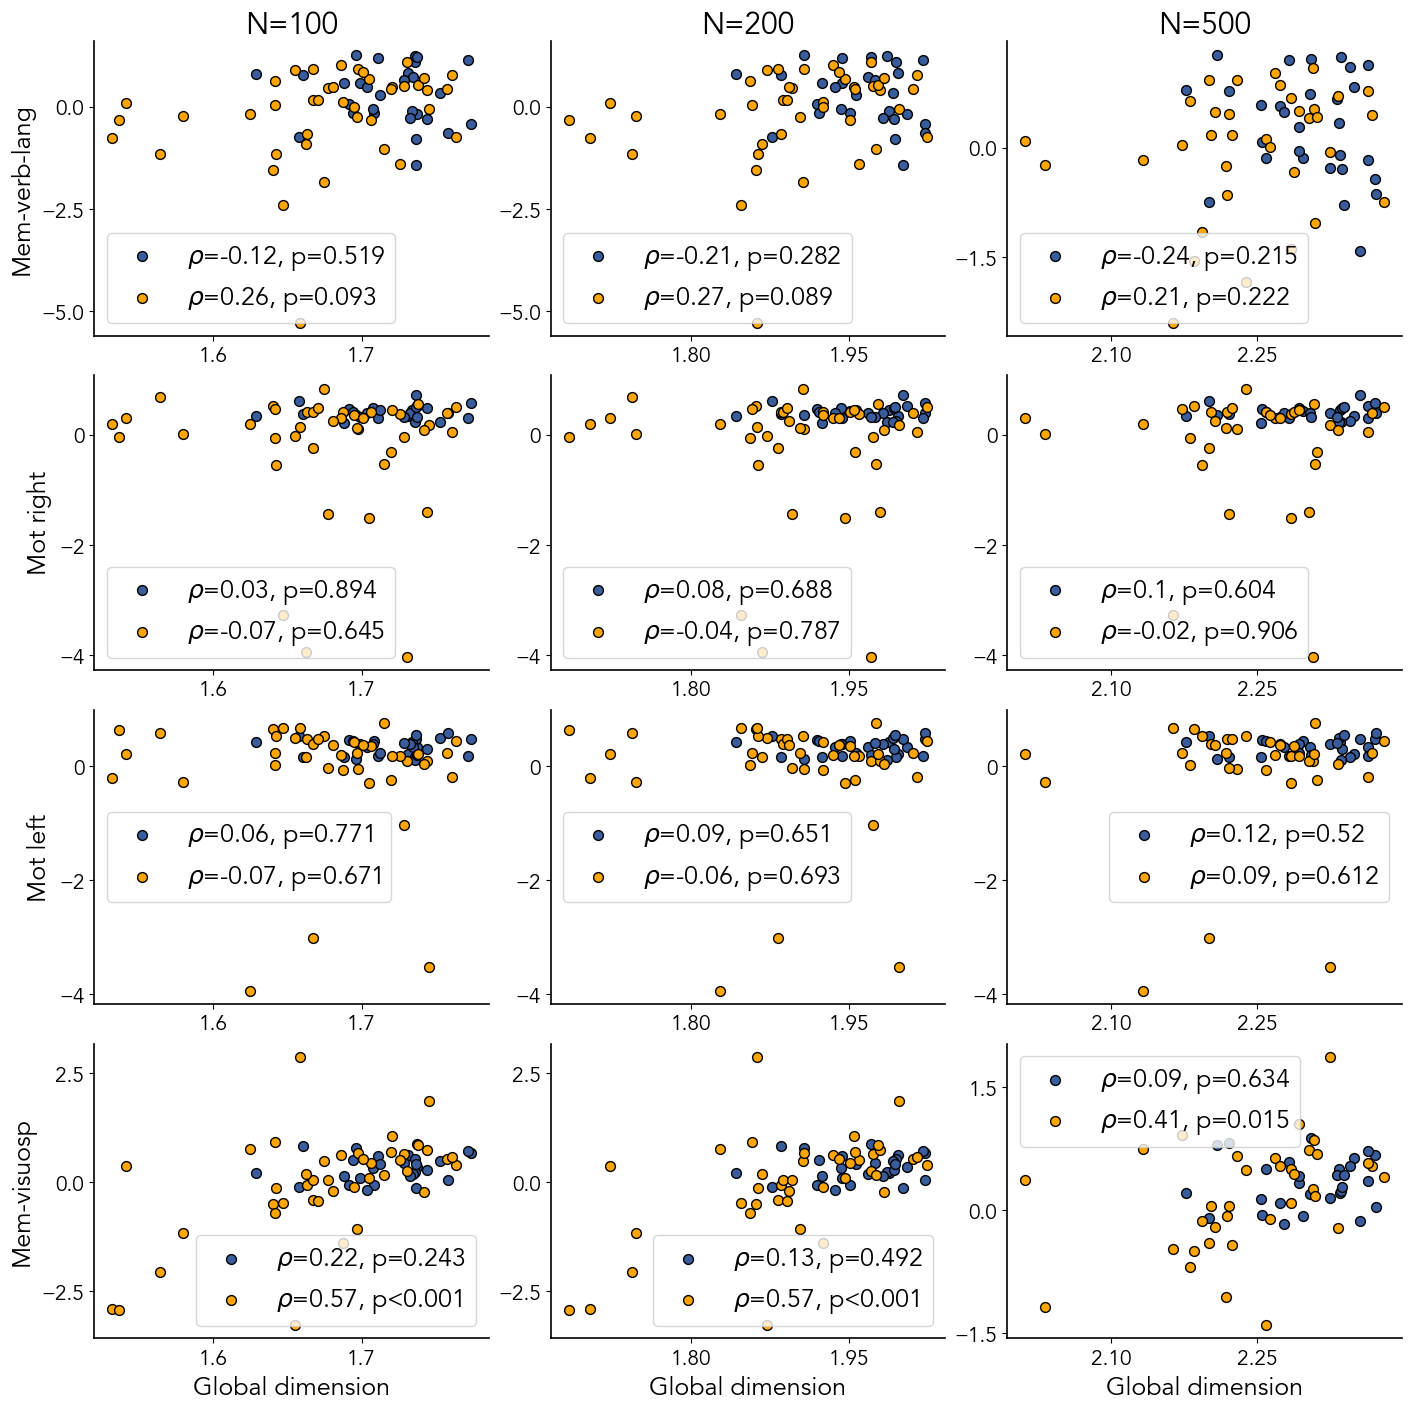

In [353]:
figsize=(14,14)
nrows = 4
ncols = 3
height_ratios = [1,1,1,1]
width_ratios = [1,1,1]
title_size = 24
ylabel_size = 20
offset = 10
letter_size = 24
legend_size = 14
fontsize_annot = 20
my_color = my_cmap(0.6)
my_colors = [my_cmap(0.6), 'orange', 'green']

### Generate figure
fig = plt.figure(figsize=figsize, layout='constrained')
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios, width_ratios=width_ratios)

axs = [fig.add_subplot(tt) for tt in gs]

### Global dimension
for idx_parc, parc in enumerate(parcellations):
    ### Get data for specific parcellation
    ress_parc = ress.loc[ress['parc'] == parc].drop(columns='parc')
    ress_parc = pd.merge(ress_parc, behavior, how="left", left_on=ress_parc.columns[:3].tolist(), right_on=behavior.columns[:3].tolist())
    
    data_control = ress_parc.loc[ress_parc['name'] == 'control'].dropna()
    data_stroke = ress_parc.loc[ress_parc['name'] == 'stroke'].dropna()

    for idx_fact, factor in enumerate(names_factor):
        ax = axs[idx_fact * len(parcellations) + idx_parc]
        
        x = data_control['dim_avg'].values
        y = data_control[factor].values
        rho, pval = pearsonr(x, y)
        if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
        else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
        ax.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)
        
        ax.xaxis.set_tick_params(labelsize=ylabel_size-5)
        ax.yaxis.set_tick_params(labelsize=ylabel_size-5)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
        
        x = data_stroke['dim_avg'].values
        y = data_stroke[factor].values
        rho, pval = pearsonr(x, y)
        if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
        else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
        ax.scatter(x, y, c=cs[1], label=label, edgecolors='black', s=50)
        
        ax.xaxis.set_tick_params(labelsize=ylabel_size-5)
        ax.yaxis.set_tick_params(labelsize=ylabel_size-5)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
        
        ax.legend()
        
        if idx_parc==0: ax.set_ylabel(factor)
        if idx_fact==0: ax.set_title(f'N={parc}')
        if idx_fact==names_factor.size-1: ax.set_xlabel('Global dimension')
        
sns.despine()

plt.savefig(folder_figures+'fig_suppl_behavior.png', dpi=200, bbox_inches='tight')

plt.show()

# Global dimension and criticality at different parcellations

In [6]:
parc = 200

### LOAD RESULTS
which = 'dimensionality'
ress_dim = load_result(which, var_name='dim', thr='mask', include_subctx=False)

which = 'criticality'
ress_crit = load_result(which, var_name='crit', thr='mask', include_subctx=False)

ress = pd.merge(ress_dim, ress_crit, how='left', left_on=ress_dim.columns[:-2].tolist(), right_on=ress_crit.columns[:-2].tolist())

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 100 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 500 - total 51 - thr mask - subctx False ########
######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 100 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########
######## stroke - ses 01 - parc 500 - total 51 - thr mask - subctx False ########


In [8]:
### GET SPECIFIC PARCELLATION
parc = 200
ress_parc = ress.loc[ress['parc'] == parc].drop(columns='parc')

crit_control = ress_parc.loc[ress_parc['name']=='control']['crit_all']
crit_control = np.stack(crit_control)

crit_stroke = ress_parc.loc[ress_parc['name']=='stroke']['crit_all']
crit_stroke = np.stack(crit_stroke)

res = np.mean(crit_control, axis=0).T
res2 = np.mean(crit_stroke, axis=0).T

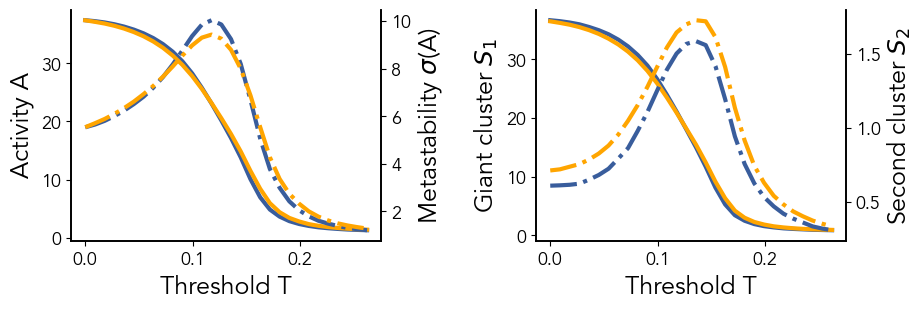

In [11]:
figsize=(10,3)
labels = ['control', 'stroke']
lw = 3

plt.figure(figsize=figsize)

ax1 = plt.subplot(1,2,1)
ax2 = ax1.twinx()

ax1.plot(res[0], res[1], c=cs[0], label=labels[0], lw=lw)
ax2.plot(res[0], res[2], c=cs[0], ls='-.', lw=lw)
    

ax1.plot(res2[0], res2[1], c=cs[1], label=labels[1], lw=lw)
ax2.plot(res2[0], res2[2], c=cs[1], ls='-.', lw=lw)

ax1.set_xlabel('Threshold T')
ax1.set_ylabel('Activity A')
ax2.set_ylabel(r'Metastability $\sigma$(A)')

ax1 = plt.subplot(1,2,2)
ax2 = ax1.twinx()

ax1.plot(res[0], res[3], c=cs[0], label=labels[0], lw=lw)
ax2.plot(res[0], res[4], c=cs[0], ls='-.', lw=lw)
    
ax1.plot(res2[0], res2[3], c=cs[1], label=labels[1], lw=lw)
ax2.plot(res2[0], res2[4], c=cs[1], ls='-.', lw=lw)

ax1.set_xlabel('Threshold T')
ax1.set_ylabel('Giant cluster $S_1$')
ax2.set_ylabel('Second cluster $S_2$')
    
#ax1.legend(ncol=2, bbox_to_anchor=[-0.3, -0.35], loc='center')
#plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
sns.despine(right=False)

plt.savefig(folder_figures+'fig_suppl_HTC.png', dpi=200, bbox_inches='tight')

plt.show()

/tmp/ipykernel_107780/572644348.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)
/tmp/ipykernel_107780/572644348.py:71: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)
/tmp/ipykernel_107780/572644348.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should 

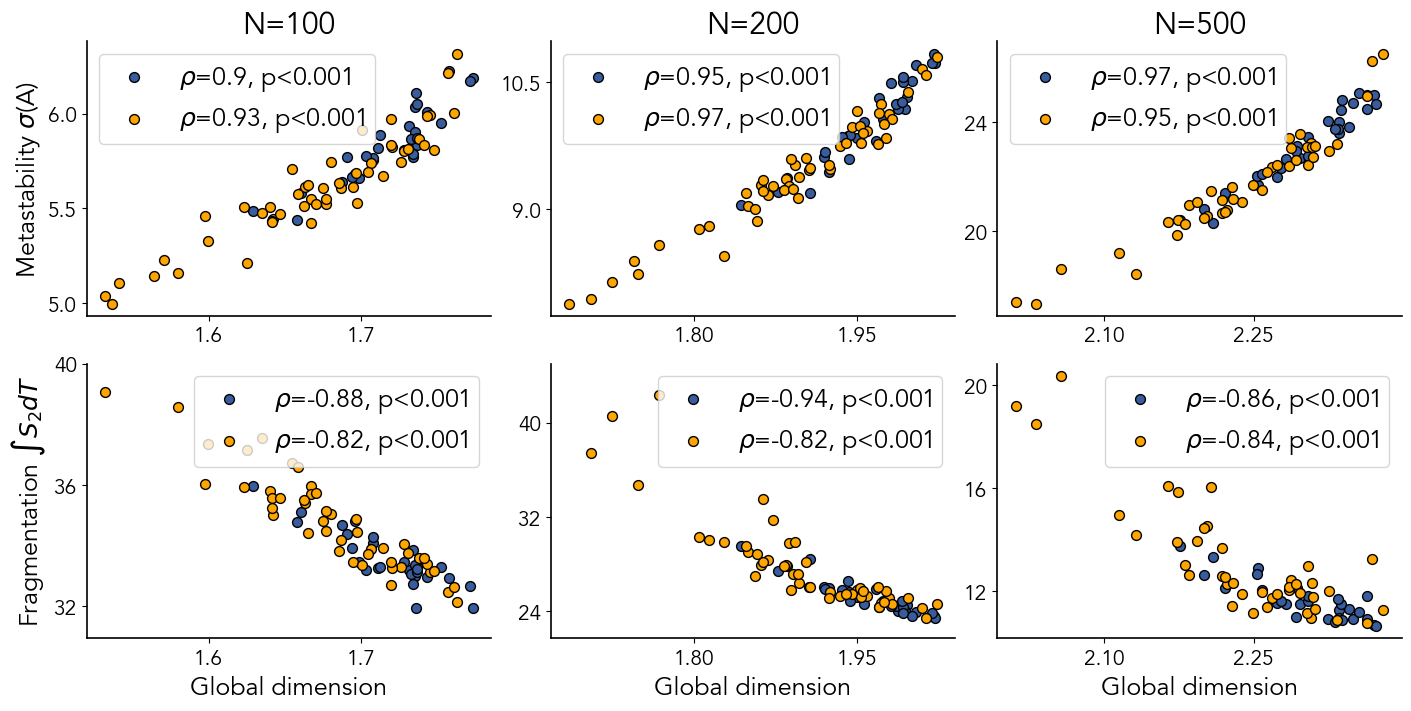

In [326]:
figsize=(14,7)
nrows = 2
ncols = 3
height_ratios = [1,1]
width_ratios = [1,1,1]
title_size = 24
ylabel_size = 20
offset = 10
letter_size = 24
legend_size = 14
fontsize_annot = 20
my_color = my_cmap(0.6)
my_colors = [my_cmap(0.6), 'orange', 'green']

x_lims = [40, 45, None]

### Generate figure
fig = plt.figure(figsize=figsize, layout='constrained')
gs = GridSpec(nrows, ncols, figure=fig, height_ratios=height_ratios, width_ratios=width_ratios)

axs = [fig.add_subplot(tt) for tt in gs]

for idx_parc, parc in enumerate(parcellations):
    
    ### GET SPECIFIC PARCELLATION
    ress_parc = ress.loc[ress['parc'] == parc].drop(columns='parc')

    crit_control = ress_parc.loc[ress_parc['name']=='control']['crit_all']
    crit_control = np.stack(crit_control)

    crit_stroke = ress_parc.loc[ress_parc['name']=='stroke']['crit_all']
    crit_stroke = np.stack(crit_stroke)
    
    ### SIGMA
    ax = axs[idx_parc]
    
    y = np.max(crit_control[:,:,2], axis=1)
    x = ress_parc.loc[ress_parc['name']=='control']['dim_avg'].values
    rho, pval = pearsonr(x, y)
    if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    ax.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)
    
    y = np.max(crit_stroke[:,:,2], axis=1)
    x = ress_parc.loc[ress_parc['name']=='stroke']['dim_avg'].values
    rho, pval = pearsonr(x, y)
    if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    ax.scatter(x, y, c=cs[1], label=label, edgecolors='black', s=50)
    
    ax.set_title(f'N={parc}')
    
    ax.xaxis.set_tick_params(labelsize=ylabel_size-5)
    ax.yaxis.set_tick_params(labelsize=ylabel_size-5)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.set_xlabel('')
    if idx_parc % ncols ==0: ax.set_ylabel('Metastability $\sigma$(A)')
    else: ax.set_ylabel('')
        
    ax.legend()
    
    ### FRAGMENTATION
    ax = axs[idx_parc + ncols]
    
    y = np.sum(crit_control[:,:,4], axis=1)
    x = ress_parc.loc[ress_parc['name']=='control']['dim_avg'].values
    rho, pval = pearsonr(x, y)
    if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    ax.scatter(x, y, c=cs[0], label=label, edgecolors='black', s=50)
    
    y = np.sum(crit_stroke[:,:,4], axis=1)
    x = ress_parc.loc[ress_parc['name']=='stroke']['dim_avg'].values
    rho, pval = pearsonr(x, y)
    if pval<1e-3: label = r'$\rho$=' + str(round(rho, 2))+ r', p<0.001'
    else: label = r'$\rho$=' + str(round(rho, 2))+ r', p=' + str(round(pval, 3))
    ax.scatter(x, y, c=cs[1], label=label, edgecolors='black', s=50)
    
    ax.set_ylim([None, x_lims[idx_parc]])
    
    ax.xaxis.set_tick_params(labelsize=ylabel_size-5)
    ax.yaxis.set_tick_params(labelsize=ylabel_size-5)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.set_xlabel('Global dimension')
    if idx_parc % ncols ==0: ax.set_ylabel(r'Fragmentation $\int S_2 dT$')
    else: ax.set_ylabel('')
        
    ax.legend()
    
sns.despine()

plt.savefig(folder_figures+'fig_suppl_criticality_parcellations.png', dpi=200, bbox_inches='tight')

plt.show()